# “数字信号处理”课程设计——工作台

本文件为课程设计项目“语音信号增采样”提供给一个设计、开发和测试的环境。

本文件也属于被评分的部分，学生需要连同课程设计报告一并提交，但请注意以下要求：
- 保留完整的增采样方法的实现代码和输出结果，并进行适当的注释和说明。
- 确保不需要任何改动（例如修改参数），可以全部直接运行和显示结果。
- 删除所有多余的调试代码、无用输出结果等。
- 本文件中可以包含原理说明、结果分析等非编程实现类的内容，但只作为学生自己参考用，教师将仅以课程设计报告中的相关内容作为评分依据。

In [1]:
# Initialization for this notebook.

import numpy as np
from scipy import signal
from scipy import fft
import matplotlib.pyplot as plt

# Import everything from `lib/dsp.py`.
from lib.dsp import *

# Un-comment the following line to use interactive matplotlib widget.
%matplotlib widget


Bad key text.latex.unicode in file D:\ISC\WPy32-3661\python-3.6.6\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file D:\ISC\WPy32-3661\python-3.6.6\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file D:\ISC\WPy32-3661\python-3.6.6\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://githu

In [2]:
# A selection of tick format functions that can be used by `analyze_filter`.
def tick_format_rad_to_pi(value, tick_number):
    """Convert value (in rad) to multiple of pi."""
    return ('%.2f' % (value/np.pi)).rstrip('0').rstrip('.') + '$\pi$'

def tick_format_append_pi(value, tick_number):
    """Append pi symbol to the value."""
    return ('%.2f' % (value)).rstrip('0').rstrip('.') + '$\pi$'

def tick_format_append_hz(value, tick_number):
    """Append Hz unit to the value."""
    return ('%.2f' % (value)).rstrip('0').rstrip('.') + 'Hz'

def analyze_filter(bands, b, a=1, show_plot=False, samples_per_band=129, fs=2, tick_format=tick_format_append_pi, amp_in_dB=True, type = 'Frequency Response'):
    """Find the R_p and A_s of the given filter and optionally show the frequency response plots.
    
    Parameters:
      bands : array_like
        A list of tuples, `(band_type, band_start, band_end)`, to describe each band.
        `band_type`: str, one of 'pass', 'tran', 'stop'
        `band_start`, `band_end`: float, the start and end frequencies, normalized to `fs`.
      b : array_like
        Numerator of the transfer function.
      a : array_like, optional
        Denominator of the transfer function. Default is 1 (FIR filter).
      show_plot : bool, optional
        Set to True to show the frequency response plots. Default is False.
      samples_per_band : int, optional
        Number of frequency samples per band (pass, transition and stop). Generally, more samples will give more accurate results. Default is 129.
      fs: float, optional
        Sampling frequency. Default is 2. (Tips: set to 2*numpy.pi for representing frequencies in rad/sample.)
      tick_format: function, optional
        Function to format tick values on x-axis. Default is `tick_format_append_pi`, which append a pi symbol to the values.
      amp_in_dB: bool, optional
        Whether the amplitude is represented in dB or not. Default is True.
    
    Returns:
      R_p: float
        Pass band ripple, in dB if amp_in_dB is True.
      A_s: float
        Stop band attenuation, in dB if amp_in_dB is True.
    """

    if amp_in_dB:
      dB = lambda x: 20 * np.log10(x)
      amp_unit = '(dB)'
    else:
      dB = lambda x: x
      amp_unit = ''

    NUM_BANDS = len(bands)
    [BAND_TYPE, BAND_START, BAND_END] = range(3)

    # Compute frequency respone samples for each band.
    w = []      # To store frequency samples for each band.
    H = []      # To store frequency respone samples for each band.
    for (band_type, w_start, w_end) in bands:
        w_tmp, H_tmp = signal.freqz(
          b=b, a=a, 
          worN=np.linspace(w_start, w_end, samples_per_band), 
          fs=fs)
        w.append(w_tmp)
        H.append(H_tmp)

    # Normalize |H| to 1.     
    H_abs = np.abs(H)
    H_norm_factor = np.max(H_abs)
    H = H / H_norm_factor
    H_abs = H_abs / H_norm_factor

    # Find the minimum pass band ripple and maximum stop band attenuation (across all respective bands).
    pass_min = 1
    stop_max = 0
    for band in range(NUM_BANDS):
      band_type = bands[band][BAND_TYPE]
      if band_type=='pass':
        pass_min = min(pass_min, np.min(H_abs[band]))
      elif band_type=='stop':
        stop_max = max(stop_max, np.max(H_abs[band]))
    pass_min, stop_max = dB(pass_min), dB(stop_max)
    
    if show_plot:
        NUM_PLOTS = 2
        [AMP_PLOT, PHASE_PLOT] = range(NUM_PLOTS)
        BAND_COLOR = {'pass':'green', 'tran':'blue', 'stop':'red'}

        fig, axs = plt.subplots(NUM_PLOTS, 1 ,sharex='col')

        # Plot the frequency response.
        for band in range(NUM_BANDS):
            band_type = bands[band][BAND_TYPE]
            axs[AMP_PLOT].plot(w[band], dB(H_abs[band]), color=BAND_COLOR[band_type])
            axs[PHASE_PLOT].plot(w[band], np.angle(H[band]), color=BAND_COLOR[band_type])
        axs[AMP_PLOT].legend([bands[band][0] for band in range(3)])
        axs[PHASE_PLOT].set_xlim(left=0, right=fs/2)
        axs[AMP_PLOT].set_title(type)
        axs[AMP_PLOT].set_ylabel('Amplitude' + amp_unit)
        axs[PHASE_PLOT].set_ylabel('Phase')
        axs[PHASE_PLOT].set_xlabel('Frequency')
        axs[AMP_PLOT].grid()
        axs[PHASE_PLOT].grid()

        # Set the tick format
        axs[PHASE_PLOT].xaxis.set_major_formatter(plt.FuncFormatter(tick_format))
        axs[PHASE_PLOT].xaxis.set_major_locator(plt.MultipleLocator(fs/8))
        axs[PHASE_PLOT].yaxis.set_major_formatter(plt.FuncFormatter(tick_format_rad_to_pi))
        axs[PHASE_PLOT].yaxis.set_major_locator(plt.MultipleLocator(np.pi/2))

        # Add horizontal lines to indicate R_p and A_s.
        axs[AMP_PLOT].axhline(y=pass_min, linestyle='--', color=BAND_COLOR['pass'])
        axs[AMP_PLOT].axhline(y=stop_max, linestyle='--', color=BAND_COLOR['stop'])
        axs[AMP_PLOT].secondary_yaxis('right').set_yticks([pass_min, stop_max])

        # Add vertical lines to indicate band egdes.
        band_edges = []
        for band in range(NUM_BANDS):
          band_type, band_start, band_end = bands[band]
          if band_type=='tran':
            for plot in range(NUM_PLOTS):
              axs[plot].axvline(band_start, linestyle='--')
              axs[plot].axvline(band_end, linestyle='--')
              band_edges.append(band_start)
              band_edges.append(band_end)
        ax_phase_top = axs[PHASE_PLOT].secondary_xaxis('top')
        ax_phase_top.xaxis.set_major_formatter(plt.FuncFormatter(tick_format))
        ax_phase_top.set_xticks(band_edges)

    if amp_in_dB:
      R_p, A_s = -pass_min, -stop_max
    else:
      R_p, A_s = pass_min, stop_max
    return R_p, A_s

## 引言

以下的代码通过对一组特定信号的频谱分析，引导学生思考如何通过数字滤波的方法实现增采样。

定义一个信号发生函数，用于生成类似语音信号的信号序列。

In [3]:
def gen_signal(fs, n):
    """Generate a test signal that comsists of several sin components."""
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((0.30, 2*np.pi/fs * 1.0e3, 0))
    x_comp.append((0.25, 2*np.pi/fs * 1.5e3, 0))
    x_comp.append((0.20, 2*np.pi/fs * 2.0e3, 0))
    x_comp.append((0.15, 2*np.pi/fs * 2.5e3, 0))
    x_comp.append((0.10, 2*np.pi/fs * 3.0e3, 0))
    
    # Generate the sequence by combining all sin components.
    x = np.sum([seq_sin(A, w, phi, 0, n-1) for A, w, phi in x_comp], axis=0)[0]

    return x

画出三个信号及其频谱：
- 低采样率(8KHz)信号 `x`
- 对 `x` 进行样本间“插零”后的信号 `x_insert_0`
- 目标高采样率(8KHz*6=48KHz)信号 `x_target`

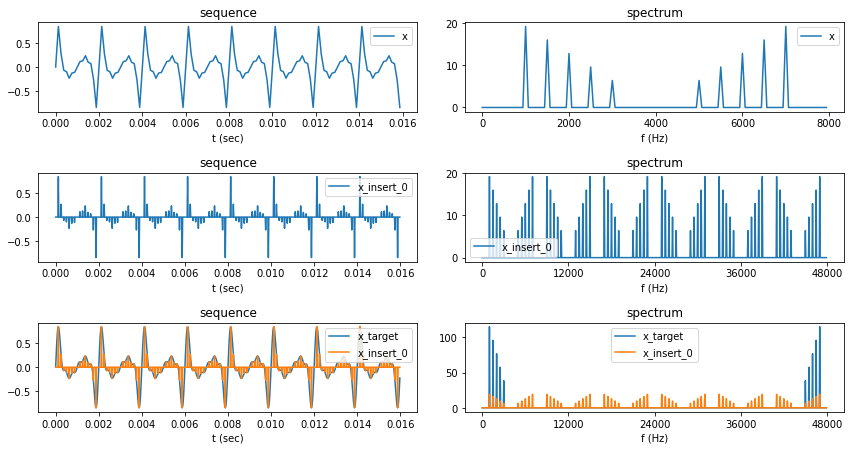

In [4]:
x_len = 128     # length of the low sampling rate signal
fs_x = 8e3      # the low sampling rate
up_factor = 6   # upsampling factor

fs_up = fs_x * up_factor
x_len_up = x_len * up_factor

# Generate the low sampling rate signal.
x = gen_signal(fs_x, x_len)

# Insert zeros between samples.
x_insert_0 = np.zeros(x_len_up)
x_insert_0[::up_factor] = x

# Generate a high sampling rate target signal.
x_target = gen_signal(fs_up, x_len_up)

# Plot the signals for inspection.
fig, axs = plt.subplots(3, 2, figsize=(12,6))
fig.tight_layout(h_pad=4)
TITLES = ['sequence', 'spectrum']
plot_signals(['x'], [x], fs_x, axs[0,:], TITLES)
plot_signals(['x_insert_0'], [x_insert_0], fs_up, axs[1,:], TITLES)
plot_signals(
    ['x_target', 'x_insert_0'],
    [x_target, x_insert_0],
    fs_up, axs[2,:],
    TITLES
)

## 基于数字滤波的增采样方法设计

基于以上信号的特点，设计一个基于数字滤波器的增采样方法。

【提示】将低采样率的信号 `x` 通过插零得到 `x_insert_0`，再输入某个数字滤波器后，得到接近目标高采样率信号 `x_target` 的信号 `x_filter`。

请按以下指引，在下文编写程序实现该方法：
- 制定数字滤波器的技术指标。
- 计算满足指标的数字滤波器的系数 `b` 和 `a`。
- 编写一个函数`upsample_filter()`，输入低采样率的信号 `x`，输出通过滤波方法得到的增采样信号 `x_filter`
- 将信号 `x_filter` 与 `x_target` 对齐画在同一个坐标系中进行比较。
  - `x_filter` 相对于 `x_target` 是有延迟，且需要经过一段时间才能达到稳定。因此，需要进行一定的处理才可得到有意义的比较。【提示】截取“有效”部分并对齐。
  通过平移来尽量对齐重叠。
- 计算 `x_filter` 与 `x_target` 有效对齐部分的 MSE（均方差）。
- 尝试不同的滤波器类型和参数，找到最优方案，即 MSE 最小的滤波器及其参数。
  - 至少尝试一种IIR和一种FIR滤波器

### FIR滤波器

type = kaiser, N = 115, R_p = 0.139227, A_s = 42.264906
b = [-6.77895647e-04 -6.68029440e-04 -4.35725276e-04  1.07838623e-18
  5.46274723e-04  1.05150890e-03  1.34361960e-03  1.28276960e-03
  8.13660727e-04 -1.74616798e-18 -9.73302479e-04 -1.83650083e-03
 -2.30478306e-03 -2.16473028e-03 -1.35281393e-03  2.50607981e-18
  1.57674853e-03  2.94156601e-03  3.65350141e-03  3.39907251e-03
  2.10586422e-03 -3.31750735e-18 -2.41777243e-03 -4.48150813e-03
 -5.53401066e-03 -5.12225325e-03 -3.15922748e-03  4.13151366e-18
  3.60164578e-03  6.65885589e-03  8.20719779e-03  7.58743692e-03
  4.67742994e-03 -4.89495406e-18 -5.33981452e-03 -9.89191600e-03
 -1.22276948e-02 -1.13492633e-02 -7.03244665e-03  5.55520438e-18
  8.14415945e-03  1.52321552e-02  1.90472231e-02  1.79246174e-02
  1.12915997e-02 -6.06501205e-18 -1.36571008e-02 -2.62839489e-02
 -3.40305768e-02 -3.34256904e-02 -2.22135719e-02  6.38695476e-18
  3.14561213e-02  6.83961353e-02  1.05652946e-01  1.37572842e-01
  1.59081360e-01  1.66668530e-

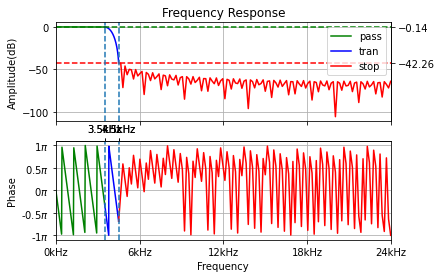

In [5]:
fs = fs_up
f_c = fs_x / 2
f_p = f_c - 0.5e3
f_st = f_c + 0.5e3
f_tran = f_st - f_p
R_p_traget = 1  # in dB
A_s_traget = 42 # in dB

#window = 'hann'
#window = 'hamming'
#window = 'blackman'
window = 'kaiser'
# 根据传入的窗函数名称参数，得到过渡带（凯泽窗除外）
if (window == 'hann'):
    window_tran = 6.2 * (fs/2)
    N = int(np.ceil(window_tran / f_tran))
elif (window == 'hamming'):
    window_tran = 6.6 * (fs/2)
    N = int(np.ceil(window_tran / f_tran))
elif (window == 'blackman'):
    window_tran = 11 * (fs/2)
    N = int(np.ceil(window_tran / f_tran))
elif (window == 'kaiser'):
    N, kaiser_beta = signal.kaiserord(A_s_traget, (f_st - f_p)/(0.5*fs))    # 计算凯泽窗口的长度N和β参数

b = signal.firwin(N, f_c, window=(window, kaiser_beta) if (window == 'kaiser') else window, fs=fs)
a = 1


# Analyze the filter.
bands= [
    ('pass', 0, f_p), 
    ('tran', f_p, f_st), 
    ('stop', f_st, fs/2)
    ]
def tick_format_to_khz(value, tick_number):
    """Show the value in kHz"""
    return ('%.2f' % (value/1000)).rstrip('0').rstrip('.') + 'kHz'
R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True, fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, N = %d, R_p = %f, A_s = %f' % (window, N, R_p, A_s))
print('b =', b)
print('a =', a)

In [6]:
def upsample_filter(x):
    # Insert zeros between samples.
    x_insert_0 = np.zeros(x_len_up)
    x_insert_0[::up_factor] = x

    x_filter = signal.lfilter(b=b, a=a, x=x_insert_0) * 6

    return x_filter

In [7]:
def comp_plots(x_filter, x_target):
    x_filter_slice = x_filter[int(np.floor(N/2))::]
    x_target_slice = x_target[0:len(x_filter_slice)]
    # Plot the signals for inspection.
    fig, axs = plt.subplots(3, 2, figsize=(12,6))
    fig.tight_layout(h_pad=4)
    TITLES = ['sequence', 'spectrum']
    plot_signals(['x_filter'], [x_filter_slice], fs_up, axs[0,:], TITLES)
    plot_signals(['x_target'], [x_target_slice], fs_up, axs[1,:], TITLES)
    plot_signals(
        ['x_target', 'x_filter'],
        [x_target_slice, x_filter_slice],
        fs_up, axs[2,:],
        TITLES
    )

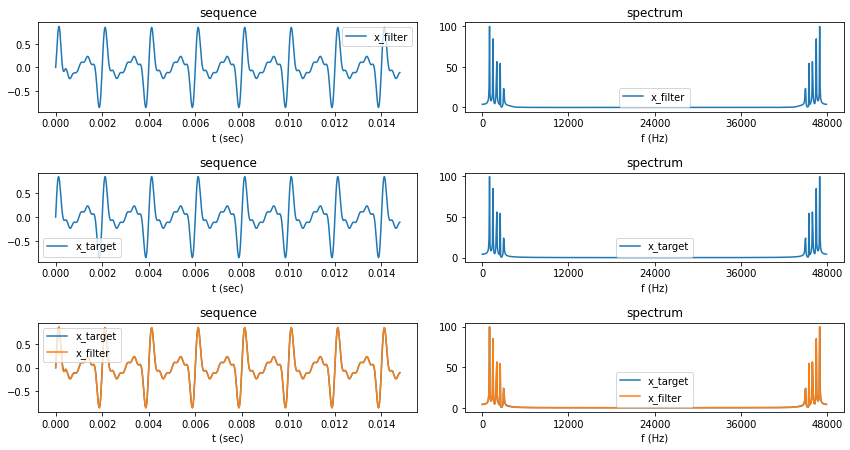

In [8]:
x_len = 128     # length of the low sampling rate signal
fs_x = 8e3      # the low sampling rate
up_factor = 6   # upsampling factor

fs_up = fs_x * up_factor
x_len_up = x_len * up_factor

# Generate the low sampling rate signal.
x = gen_signal(fs_x, x_len)

# Generate a high sampling rate target signal.
x_target = gen_signal(fs_up, x_len_up)


x_filter = upsample_filter(x)
comp_plots(x_filter, x_target)

In [9]:
def cal_MSE(x_filter, x_target):
    x_filter_slice = x_filter[int(np.floor(N/2))::]
    x_target_slice = x_target[0:len(x_filter_slice)]

    if (len(x_filter_slice) == len(x_target_slice)):
        return ( sum((x_target_slice-x_filter_slice)**2) / len(x_filter_slice) )

cal_MSE(x_filter, x_target)


0.0001246294739115957

汉宁:       0.00012730336879477908  N = 149  
海明:       0.00013096570925074288  N = 159  
布莱克曼:   0.0012948544950448315   N = 264  
凯泽：      0.0001246294739115957  N = 115

### IIR滤波器

type = cheby2, order = 9, R_p = 1.000000, A_s = 42.000001
b = [ 0.01008596 -0.03949653  0.07627619 -0.08126411  0.03589419  0.03589419
 -0.08126411  0.07627619 -0.03949653  0.01008596]
a = [  1.          -5.76089253  15.1910968  -23.9091114   24.6614943
 -17.24215288   8.15521846  -2.5121307    0.45669963  -0.03723027]


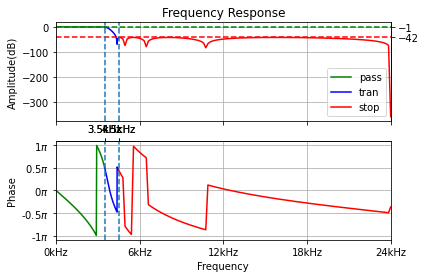

In [10]:
fs = fs_up
f_c = fs_x / 2
f_p = f_c - 0.5e3
f_st = f_c + 0.5e3
f_tran = f_st - f_p
R_p_traget = 1  # in dB
A_s_traget = 42 # in dB

## Uncomment only one of the following:
#ftype='butter'
#ftype='cheby1'
ftype='cheby2'
#ftype='ellip'

b, a = signal.iirdesign(
    f_p, f_st, 
    R_p_traget, A_s_traget,
    ftype=ftype,
    fs=fs)
forder = max(len(b), len(a)) - 1

# Analyze the filter.
bands= [
    ('pass', 0, f_p), 
    ('tran', f_p, f_st), 
    ('stop', f_st, fs/2)
    ]
R_p, A_s = analyze_filter(bands, b=b, a=a, show_plot=True, fs=fs, tick_format=tick_format_to_khz, amp_in_dB=True)
print('type = %s, order = %d, R_p = %f, A_s = %f' % (ftype, forder, R_p, A_s))
print('b =', b)
print('a =', a)

In [11]:
def comp_plots(x_filter, x_target):
    x_filter_slice = x_filter[int(np.floor(5))::]
    x_target_slice = x_target[0:len(x_filter_slice)]
    # Plot the signals for inspection.
    fig, axs = plt.subplots(3, 2, figsize=(12,6))
    fig.tight_layout(h_pad=4)
    TITLES = ['sequence', 'spectrum']
    plot_signals(['x_filter'], [x_filter_slice], fs_up, axs[0,:], TITLES)
    plot_signals(['x_target'], [x_target_slice], fs_up, axs[1,:], TITLES)
    plot_signals(
        ['x_target', 'x_filter'],
        [x_target_slice, x_filter_slice],
        fs_up, axs[2,:],
        TITLES
    )

def cal_MSE(x_filter, x_target):
    x_filter_slice = x_filter[int(np.floor(forder))::]
    x_target_slice = x_target[0:len(x_filter_slice)]

    if (len(x_filter_slice) == len(x_target_slice)):
        return ( sum((x_target_slice-x_filter_slice)**2) / len(x_filter_slice) )

0.016399890858700673

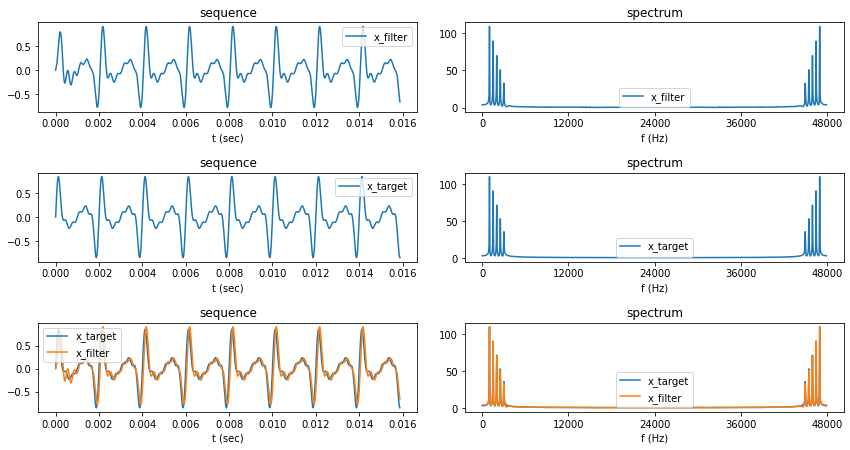

In [12]:
x_filter = upsample_filter(x)

comp_plots(x_filter, x_target)

cal_MSE(x_filter, x_target)

## 基于时域插值的增采样方法

查阅资料，学习最近邻域插值(nearest neighbour interpolation)、线性插值(linear interpolation)的基本原理。

【提示】可以利用现成的函数库进行插值计算。

请按以下指引，在下文编写程序实现该方法：
- 编写一个函数 `upsample_interp()`，输入低采样率的信号 `x`，输出通过插值方法得到的增采样信号 `x_interp`。
- 将信号 `x_interp` 与 `x_target` 对齐画在同一个坐标系中进行比较。
  - 注意 `x_interp` 相对于 `x_target` 是否有延迟，是否需要截取“有效”部分并对齐。
- 计算 `x_interp` 与 `x_target` 有效对齐部分的 MSE（均方差）。
- 尝试不同插值类型，找到最优方案，即 MSE 最小插值类型出。